<div class="alert alert-info">

## **Experiments**

In this notebook we test extracting features from the videos using different feature extractors & with then train a Dense and LSTM network on the extracted features.

</div>

<div class="alert alert-success">

- [ ] Retry experiments but with normalized features or Batch Normalization & more complex networks.
- [ ] Try with YOLO centered key points to the body center.
- [ ] Try with all features + appended optical flow or yolo key points.

</div>

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
import tqdm
import torch
import torchvision

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from enum import IntEnum
from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix

from video_dataset import VideoDataset
from video_dataset.padder import LastValuePadder
from video_dataset.dataset import VideoShapeComponents
from video_dataset.video import VideoFromVideoFramesDirectory
from video_dataset.preprocessor import extract_frames_from_videos
from video_dataset.annotations import AnnotationsFromSegmentLevelCsvFileAnnotations

from tas_helpers.visualization import SegmentationVisualizer
from tas_helpers.scores import repetition_score, order_variation_score
from tas_helpers.metrics import mean_over_frames, f1_score, edit_distance

from extractors import \
    FeatureExtractor, \
    ResNet3DFeatureExtractor, \
    DinoFeatureExtractor, \
    I3DFeatureExtractor, \
    ClipFeatureExtractor, \
    YoloFeatureExtractor, \
    IJepaFeatureExtractor, \
    S3DKineticsFeatureExtractor, \
    S3DHowTo100MFeatureExtractor, \
    X3DSFeatureExtractor, \
    SlowFastFeatureExtractor

from cached_dataset.dataset import DiskCachedDataset

from utils import LabelEncoderFactory

/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

print(f"[model.blocks[-1]]: {model.blocks[-1]}")

model.blocks[-1].proj = torch.nn.Identity()

print(f"[model.blocks[-1]]: {model.blocks[-1]}")

Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


[model.blocks[-1]]: ResNetBasicHead(
  (dropout): Dropout(p=0.5, inplace=False)
  (proj): Linear(in_features=2304, out_features=400, bias=True)
  (output_pool): AdaptiveAvgPool3d(output_size=1)
)
[model.blocks[-1]]: ResNetBasicHead(
  (dropout): Dropout(p=0.5, inplace=False)
  (proj): Identity()
  (output_pool): AdaptiveAvgPool3d(output_size=1)
)


In [3]:
extractor = SlowFastFeatureExtractor()

example_clip = torch.zeros((3, 32, 256, 256))

features = extractor.transform_and_extract(example_clip)

print(f"[features.shape]: {features.shape}")

Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
/Users/nadir/Documents/code/extractors.py:465: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),


[features.shape]: torch.Size([2304])


In [4]:
DATASET_PATH = "/Users/nadir/Documents/research-project-dataset"

VIDEOS_DIRECTORY_NAME = "videos"
ANNOTATIONS_DIRECTORY_NAME = "annotations"
VIDEOS_FRAMES_DIRECTORY_NAME = "videos_frames"

TESTING_IDS_FILE_NAME = "testing_ids.txt"
TRAINING_IDS_FILE_NAME = "training_ids.txt"
VALIDATION_IDS_FILE_NAME = "validation_ids.txt"

UNANNOTATED_IDS_FILE_NAME = "unannotated_ids.txt"

FEATURES_EXTRACTORS = [
    {
        "name": "averaged-dino",
        "features-directory-name": "features/averaged-dino-features",
        "extractor": DinoFeatureExtractor(average_pool=True),
        "#frames": 8,
    },
    # {
    #     "name": "dino",
    #     "features-directory-name": "features/dino-features",
    #     "extractor": DinoFeatureExtractor(average_pool=False),
    #     "#frames": 8,
    # },
    {
        "name": "resnet-3d",
        "features-directory-name": "features/resnet-3d-features",
        "extractor": ResNet3DFeatureExtractor(),
        "#frames": 8,
    },
    {
        "name": "i3d",
        "features-directory-name": "features/i3d-features",
        "extractor": I3DFeatureExtractor(),
        "#frames": 16,
    },
    # {
    #     "name": "clip",
    #     "features-directory-name": "features/clip-features",
    #     "extractor": ClipFeatureExtractor(average_pool=True),
    #     "#frames": 8,
    # },
    {
        "name": "averaged-clip",
        "features-directory-name": "features/averaged-clip-features",
        "extractor": ClipFeatureExtractor(average_pool=False),
        "#frames": 8,
    },
    {
        "name": "averaged-yolo",
        "features-directory-name": "features/averaged-yolo-features",
        "extractor": YoloFeatureExtractor(average_pool=True),
        "#frames": 8,
    },
    # {
    #     "name": "yolo",
    #     "features-directory-name": "features/yolo-features",
    #     "extractor": YoloFeatureExtractor(average_pool=False),
    #     "#frames": 8,
    # },
    {
        "name": "averaged-i-jepa",
        "features-directory-name": "features/averaged-i-jepa-features",
        "extractor": IJepaFeatureExtractor(average_pool=True),
        "#frames": 8,
    },
    # {
    #     "name": "i-jepa",
    #     "features-directory-name": "features/i-jepa-features",
    #     "extractor": IJepaFeatureExtractor(average_pool=False),
    #     "#frames": 8,
    # },
    {
        "name": "s3d-kinetics",
        "features-directory-name": "features/s3d-kinetics-features",
        "extractor": S3DKineticsFeatureExtractor(),
        "#frames": 16,
    },
    {
        "name": "s3d-howto100m",
        "features-directory-name": "features/s3d-howto100m-features",
        "extractor": S3DHowTo100MFeatureExtractor(),
        "#frames": 16,
    },
    {
        "name": "x3d-s",
        "features-directory-name": "features/x3d-s-features",
        "extractor": X3DSFeatureExtractor(),
        "#frames": 16,
    },
    {
        "name": "slowfast",
        "features-directory-name": "features/slowfast-features",
        "extractor": SlowFastFeatureExtractor(),
        "#frames": 32,
    },
]

Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


[missing-keys]: <All keys matched successfully>


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [5]:
label_encoder = LabelEncoderFactory.get()

In [6]:
extract_frames_from_videos(
    videos_dir=os.path.join(DATASET_PATH, VIDEOS_DIRECTORY_NAME),
    output_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
)

[INFO]: frames for "climb_1-climber_MoubeAdrian-bloc_1-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_1-climber_MoubeAdrian-bloc_1-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_10-climber_DouglasSophia-bloc_1-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_10-climber_DouglasSophia-bloc_1-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_11-climber_MoubeAdrian-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_11-climber_MoubeAdrian-bloc_2-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_12-climber_MrideEsteban-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_12-climber_MrideEsteban-bloc_2-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_13-climber_FonneLana-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_13-climber_FonneLana-blo

In [7]:
def __aggregate_labels(str_labels):
    labels = label_encoder.transform(str_labels)
    
    unique_elements, counts = np.unique(labels, return_counts=True)

    max_count_index = np.argmax(counts)

    most_frequent_element = unique_elements[max_count_index]
    
    return most_frequent_element

In [8]:
def derive_step_from_required_number_of_frames(required_number_of_frames, segment_size):
    return int(np.ceil(segment_size / required_number_of_frames))

In [9]:
class DatasetVariants(IntEnum):
    TRAINING = 0
    TESTING = 1
    VALIDATION = 2
    UNANNOTATED = 3

def dataset_with_transform(transform, variant, step):
    if variant == DatasetVariants.TESTING:
        ids_file = TESTING_IDS_FILE_NAME
    elif variant == DatasetVariants.TRAINING:
        ids_file = TRAINING_IDS_FILE_NAME
    elif variant == DatasetVariants.UNANNOTATED:
        ids_file = VALIDATION_IDS_FILE_NAME
    elif variant == DatasetVariants.UNANNOTATED:
        ids_file = UNANNOTATED_IDS_FILE_NAME
    else:
        raise ValueError("Unknown dataset variant")
    
    return VideoDataset(
        annotations_dir=os.path.join(DATASET_PATH, ANNOTATIONS_DIRECTORY_NAME),
        videos_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
        ids_file=os.path.join(DATASET_PATH, ids_file),
        segment_size=32,
        video_processor=VideoFromVideoFramesDirectory,
        annotations_processor=AnnotationsFromSegmentLevelCsvFileAnnotations,
        annotations_processor_kwargs={"fps": 25, "delimiter": ","},
        video_shape=(VideoShapeComponents.CHANNELS, VideoShapeComponents.TIME, VideoShapeComponents.HEIGHT, VideoShapeComponents.WIDTH),
        step=step,
        # padder=LastValuePadder(),
        frames_transform=transform,
        annotations_transform=__aggregate_labels,
        overlap=0,
        allow_undefined_annotations=False
    )

In [10]:
datasets = {
    "training": [
        dataset_with_transform(
            extractor["extractor"].transform_and_extract,
            DatasetVariants.TRAINING,
            derive_step_from_required_number_of_frames(extractor["#frames"], 32)
        ) for extractor in FEATURES_EXTRACTORS],
    "testing": [
        dataset_with_transform(
            extractor["extractor"].transform_and_extract,
            DatasetVariants.TESTING,
            derive_step_from_required_number_of_frames(extractor["#frames"], 32)
        ) for extractor in FEATURES_EXTRACTORS],
}

[warning]: 24 frames will be lost, because video 0 has 6296 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 12 frames will be lost, because video 1 has 6284 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 4 frames will be lost, because video 2 has 6020 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 29 frames will be lost, because video 3 has 6269 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 26 frames will be lost, because video 4 has 5786 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 22 frames will be lost, because video 5 has 5814 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 3 frames will be lost, because video 6 has 6019 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 25 frames will be lost, because video 7

In [11]:
for dataset, extractor in zip(datasets["training"], FEATURES_EXTRACTORS):
    print(f"[{extractor['name']}]:", end=" ")
    print(dataset[0][0].shape)

[averaged-dino]: torch.Size([384])
[resnet-3d]: torch.Size([2048])
[i3d]: torch.Size([1024])
[averaged-clip]: torch.Size([8, 512])
[averaged-yolo]: 

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


torch.Size([51])
[averaged-i-jepa]: torch.Size([1280])
[s3d-kinetics]: torch.Size([1024])
[s3d-howto100m]: torch.Size([1024])
[x3d-s]: torch.Size([2048])
[slowfast]: torch.Size([2304])


In [13]:
cached_datasets = {
    "training": [],
    "testing": []
}

for training_dataset, testing_dataset, extractor in zip(datasets["training"], datasets["testing"], FEATURES_EXTRACTORS):
    print(f"[caching-dataset]({extractor['name']}.training):")
    training_dataset = DiskCachedDataset.load_dataset_or_cache_it(
        dataset=training_dataset,
        base_path=os.path.join(DATASET_PATH, extractor["features-directory-name"], "training"),
        verbose=True
    )
        
    cached_datasets["training"].append(training_dataset)
    
    print(f"[caching-dataset]({extractor['name']}.testing):")
    # testing_dataset = DiskCachedDataset(
    #     dataset=testing_dataset,
    #     base_path=os.path.join(DATASET_PATH, extractor["features-directory-name"], "testing"),
    #     verbose=True
    # )
    testing_dataset = DiskCachedDataset(
        # dataset=testing_dataset,
        base_path=os.path.join(DATASET_PATH, extractor["features-directory-name"], "testing"),
        verbose=True
    )
    
    cached_datasets["testing"].append(testing_dataset)

[caching-dataset](averaged-dino.training):
[caching-dataset](averaged-dino.testing):
[caching-dataset](resnet-3d.training):
[caching-dataset](resnet-3d.testing):
[caching-dataset](i3d.training):
[caching-dataset](i3d.testing):
[caching-dataset](averaged-clip.training):
[caching-dataset](averaged-clip.testing):
[caching-dataset](averaged-yolo.training):
[caching-dataset](averaged-yolo.testing):
[caching-dataset](averaged-i-jepa.training):
[caching-dataset](averaged-i-jepa.testing):
[caching-dataset](s3d-kinetics.training):
[caching-dataset](s3d-kinetics.testing):
[caching-dataset](s3d-howto100m.training):
[caching-dataset](s3d-howto100m.testing):
[caching-dataset](x3d-s.training):
[caching-dataset](x3d-s.testing):
[caching-dataset](slowfast.training):
[caching-dataset](slowfast.testing):


<div class="alert alert-info">

**Estimated Dataset Looping Time:** 16-18mins.

**Estimated dataset pass with Feature Extraction:** 45-60mins.

</div>

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

In [15]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearClassifier, self).__init__()
        
        self.fc = torch.nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.fc(x)

In [16]:
class ComplexLinearClassifier(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, dropout_rate=0.3):
        super(ComplexLinearClassifier, self).__init__()
        
        # First hidden layer
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.bn1 = torch.nn.BatchNorm1d(hidden_size)
        self.relu1 = torch.nn.ReLU()
        
        # Second hidden layer
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.bn2 = torch.nn.BatchNorm1d(hidden_size)
        self.relu2 = torch.nn.ReLU()
        
        # Output layer
        self.fc3 = torch.nn.Linear(hidden_size, output_size)
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout_rate)
    
    def forward(self, x):
        # Forward pass with hidden layers and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

<div class="alert alert-info">

The idea is that the model should be aware of previous classification. So maybe it should operate at batch level or idk what.

</div>

In [17]:
class TemporallyAwareModel(torch.nn.Module):
    def __init__(self, input_size, number_of_classes):
        super(TemporallyAwareModel, self).__init__()
        
        self.input_size = input_size
        self.number_of_classes = number_of_classes

        self.__init_modules()
        
    def __init_modules(self):
        self.flattener = torch.nn.Flatten()
        
        # TODO: experiment with keeping the hidden_size the same as the input size / feature size
        self.lstm = torch.nn.LSTM(input_size=self.input_size, hidden_size=512, num_layers=2, batch_first=True)
        
        self.classifier = torch.nn.Linear(512, self.number_of_classes)
        
    def forward(self, clip_features):
        # clip_features should have shape: [B, T, F] where B=batch size, T=8 frames, F=384 features per frame

        lstm_out, (hn, cn) = self.lstm(clip_features)  # lstm_out: [B, T, H]
        
        # Use the last hidden state (hn) from the LSTM for classification
        lstm_out_last = hn[-1]  # Last hidden state from the last layer of LSTM

        label = self.classifier(lstm_out_last)

        return label
    
    def get_number_of_parameters(self):
        return sum(parameter.numel() for parameter in self.parameters() if parameter.requires_grad)

In [18]:
class Trainer():
    def __init__(self, model):
        self.model = model
        
    def train_one_epoch(self, dataloader, learning_rate):
        self.model.train()
        
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        total_loss = 0.0
        num_batches = 0
        correct = 0
        total = 0
        
        for features, labels in dataloader:
            optimizer.zero_grad()
            
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = self.model.forward(features)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            total_loss += loss.item()
            num_batches += 1
        
        accuracy = correct / total
        
        return total_loss / num_batches, accuracy
            
    def validate(self, dataloader):
        self.model.eval()
        
        criterion = torch.nn.CrossEntropyLoss()
        total_loss = 0.0
        num_batches = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for features, labels in dataloader:
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = self.model.forward(features)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                total_loss += loss.item()
                num_batches += 1
        
        return total_loss / num_batches, correct / total

In [19]:
best_scores = {
    "training": {},
    "validation": {},
    "epoch": {}
}

training_history = {}
validation_history = {}

classifiers = []

for extractor, training_dataset, testing_dataset in zip(FEATURES_EXTRACTORS, cached_datasets["training"], cached_datasets["testing"]):
    print(f"[classifier]({extractor['name']}):")
    
    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
    testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=32, shuffle=False)
    
    classifier = LinearClassifier(input_size=training_dataset[0][0].shape[0], output_size=len(label_encoder.classes_)).to(device)
    
    trainer = Trainer(classifier)
    
    classifiers.append(classifier)

    # NOTE: initialize history tracking for this model
    training_history[extractor["name"]] = {
        "loss": [],
        "accuracy": []
    }
    validation_history[extractor["name"]] = {
        "loss": [],
        "accuracy": []
    }
    
    best_validation_accuracy = 0
    best_training_accuracy = 0
    best_epoch = 0
    
    for epoch in range(16):
        training_loss, training_accuracy = trainer.train_one_epoch(training_dataloader, learning_rate=0.001)
        validation_loss, validation_accuracy = trainer.validate(testing_dataloader)
        
        # NOTE: store history
        training_history[extractor["name"]]["loss"].append(training_loss)
        training_history[extractor["name"]]["accuracy"].append(training_accuracy)
        validation_history[extractor["name"]]["loss"].append(validation_loss)
        validation_history[extractor["name"]]["accuracy"].append(validation_accuracy)
        
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_training_accuracy = training_accuracy
            best_epoch = epoch
        
        print(f"[{extractor['name']}.epoch={epoch}]: validation-accuracy={(validation_accuracy * 100):.2f}%; training-accuracy={(training_accuracy * 100):.2f}%;training-loss={training_loss:.4f}")

    best_scores["training"][extractor["name"]] = best_training_accuracy
    best_scores["validation"][extractor["name"]] = best_validation_accuracy
    best_scores["epoch"][extractor["name"]] = best_epoch
    
    print(f"[classifier]({extractor['name']}): done.")
    print(f"[classifier]({extractor['name']}): best scores are validation={best_validation_accuracy*100:.2f}%; training={best_training_accuracy*100:.2f}%; at epoch {best_epoch}")

[classifier](averaged-dino):
[averaged-dino.epoch=0]: validation-accuracy=63.13%; training-accuracy=61.57%;training-loss=1.1064
[averaged-dino.epoch=1]: validation-accuracy=64.09%; training-accuracy=69.96%;training-loss=0.8771
[averaged-dino.epoch=2]: validation-accuracy=66.11%; training-accuracy=73.00%;training-loss=0.8134
[averaged-dino.epoch=3]: validation-accuracy=63.48%; training-accuracy=73.07%;training-loss=0.7925
[averaged-dino.epoch=4]: validation-accuracy=66.29%; training-accuracy=72.90%;training-loss=0.7753
[averaged-dino.epoch=5]: validation-accuracy=63.65%; training-accuracy=74.45%;training-loss=0.7549
[averaged-dino.epoch=6]: validation-accuracy=65.58%; training-accuracy=74.89%;training-loss=0.7412
[averaged-dino.epoch=7]: validation-accuracy=67.34%; training-accuracy=76.14%;training-loss=0.7350
[averaged-dino.epoch=8]: validation-accuracy=63.92%; training-accuracy=75.87%;training-loss=0.7150
[averaged-dino.epoch=9]: validation-accuracy=63.92%; training-accuracy=75.77%;tr

<div class="alert alert-success">

- [ ] Try using an LSTM for per frame embedding.

</div>

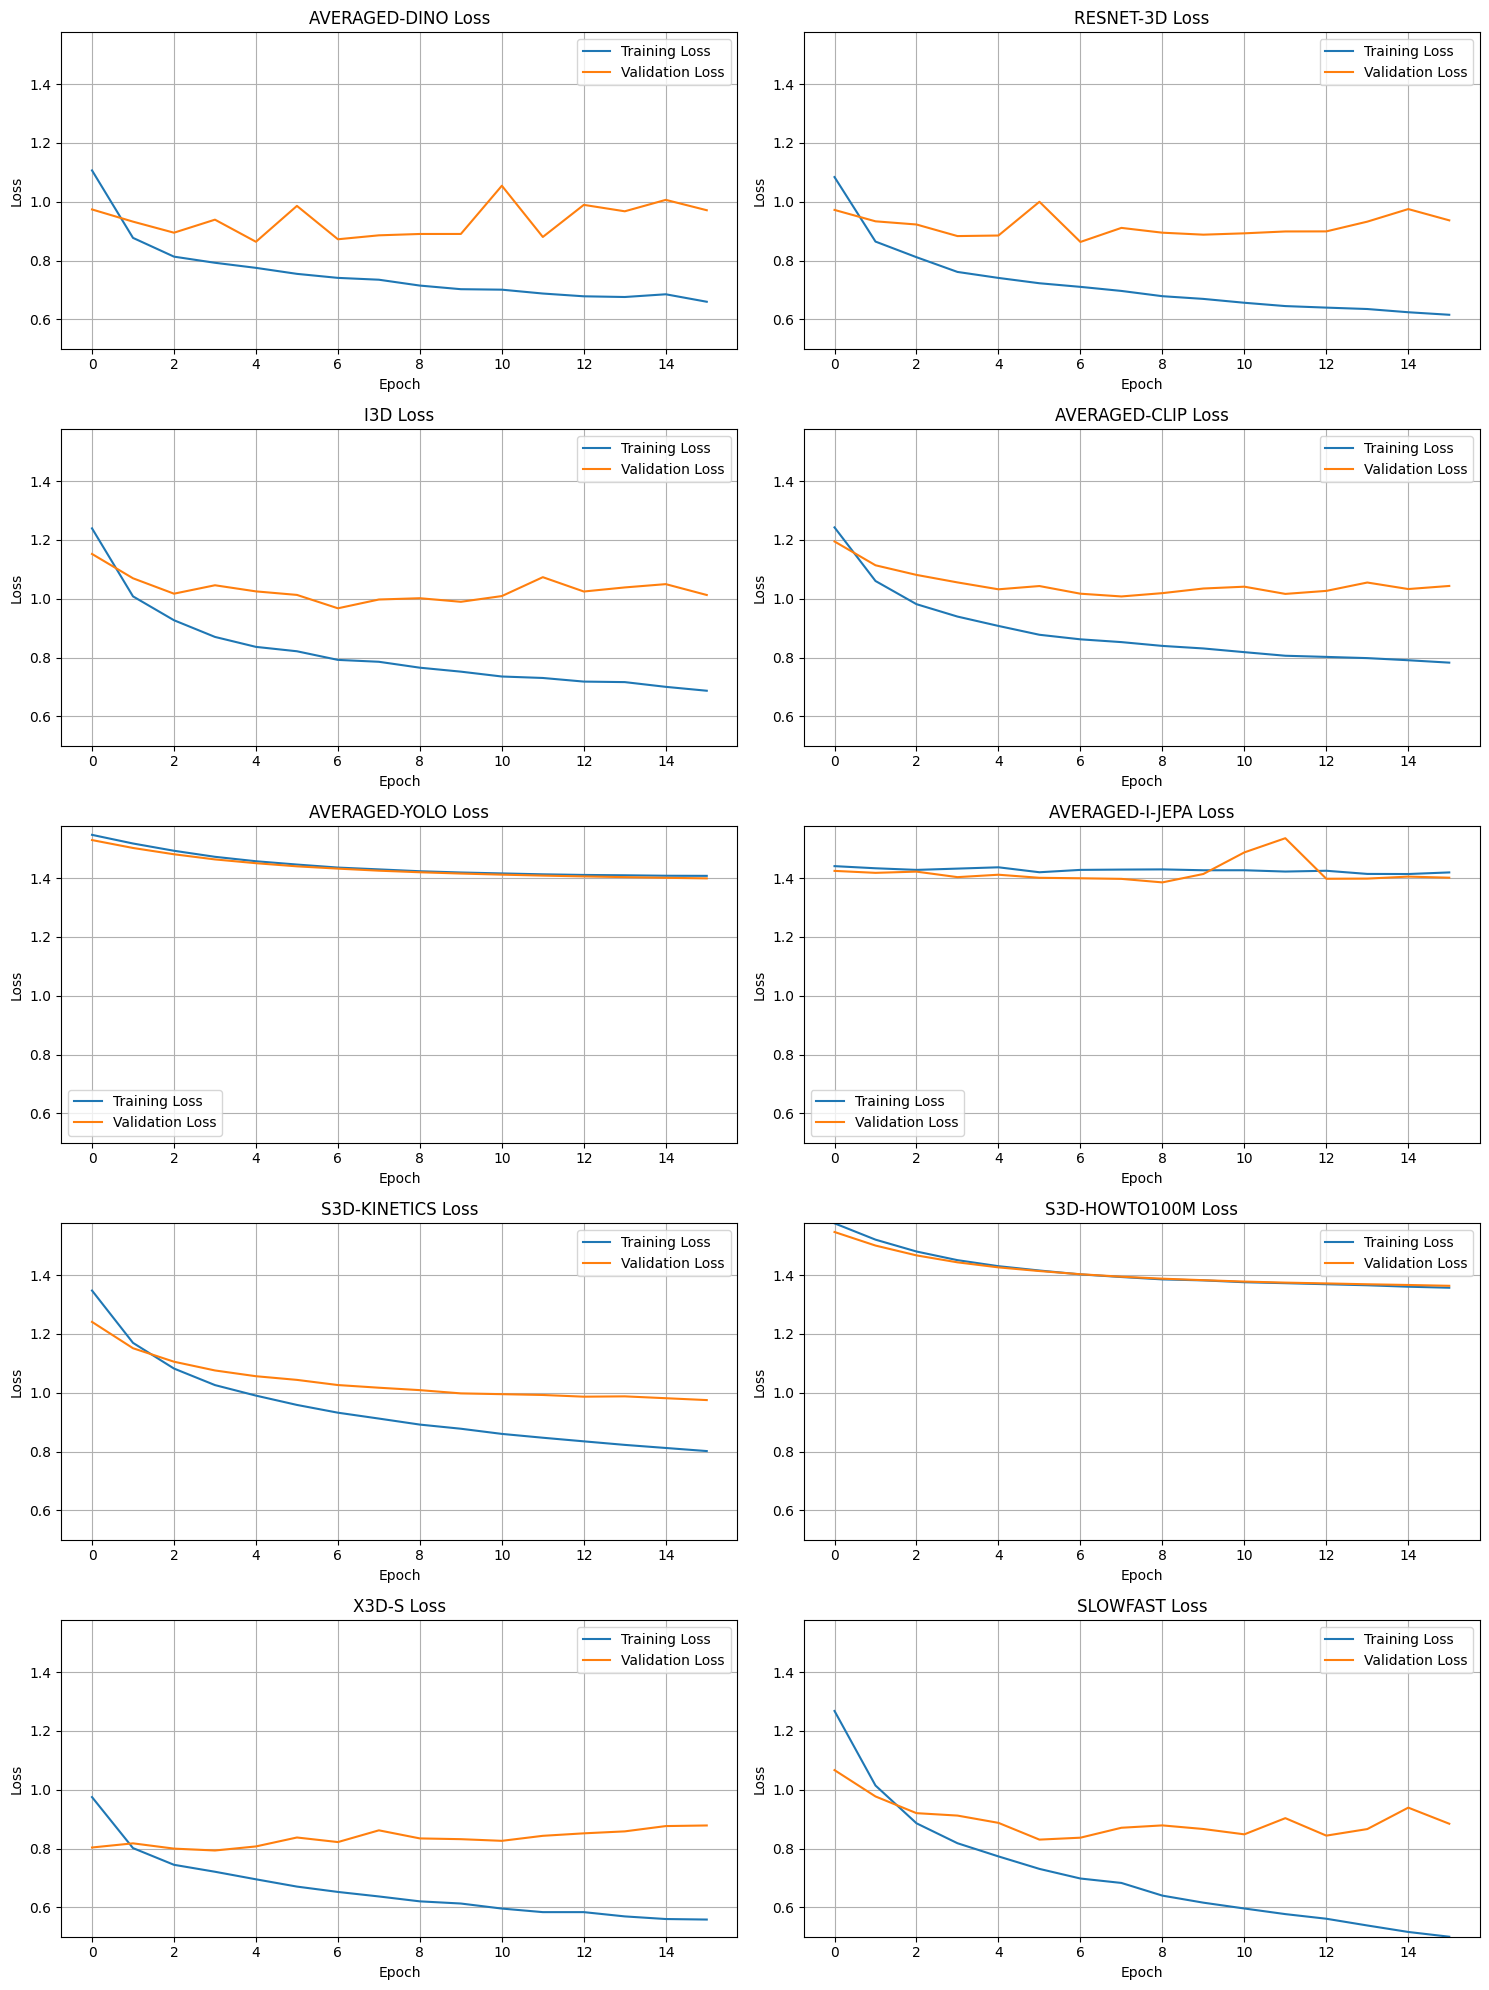

In [ ]:
number_of_models = len(FEATURES_EXTRACTORS)

figure, axes = plt.subplots(nrows=(number_of_models+1)//2, ncols=2, figsize=(15, 4*((number_of_models+1)//2)))
axes = axes.flatten()

min_loss = float('inf')
max_loss = float('-inf')

for extractor in FEATURES_EXTRACTORS:
    name = extractor['name']
    min_loss = min(min_loss, 
                  min(training_history[name]['loss']), 
                  min(validation_history[name]['loss']))
    max_loss = max(max_loss, 
                   max(training_history[name]['loss']), 
                   max(validation_history[name]['loss']))

for idx, extractor in enumerate(FEATURES_EXTRACTORS):
    name = extractor['name']
    
    axes[idx].plot(training_history[name]['loss'], label='Training Loss')
    axes[idx].plot(validation_history[name]['loss'], label='Validation Loss')
    
    axes[idx].set_title(f'{name.upper()} Loss')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid(True)
    
    axes[idx].set_ylim(min_loss, max_loss)

if number_of_models % 2 != 0:
    figure.delaxes(axes[-1])

plt.tight_layout()
plt.show()

[len(model_names)]: 10
[len(markers)]: 10


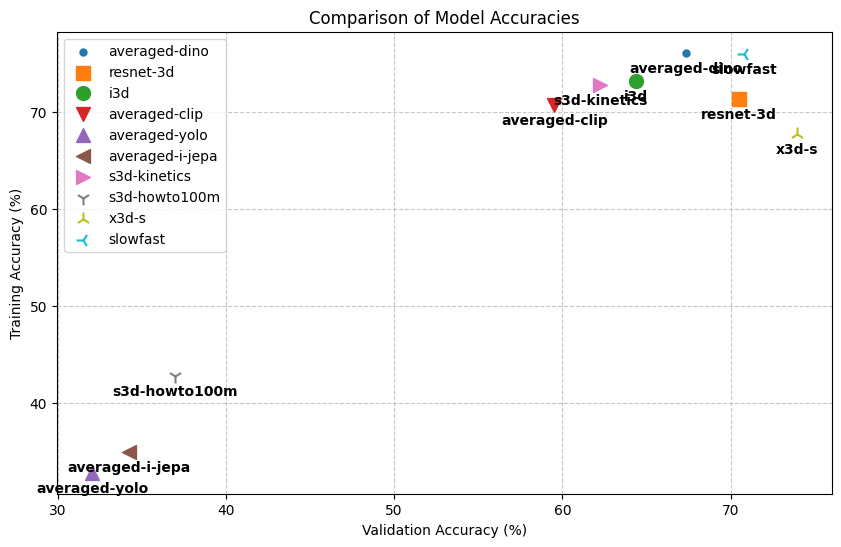

In [21]:
model_names = list(best_scores["validation"].keys())

validation_accuracies = [best_scores["validation"][name] * 100 for name in model_names]
training_accuracies = [best_scores["training"][name] * 100 for name in model_names]

markers = list(Line2D.markers.keys())
markers = markers[:len(model_names)]

print(f"[len(model_names)]: {len(model_names)}")
print(f"[len(markers)]: {len(markers)}")

plt.figure(figsize=(10, 6))

for i, (name, val_acc, train_acc, marker) in enumerate(zip(model_names, validation_accuracies, training_accuracies, markers)):
    plt.scatter(val_acc, train_acc, label=name, marker=marker, s=100)
    plt.text(val_acc, train_acc - 2, name, ha='center', fontsize=10, fontweight='bold')

plt.xlabel("Validation Accuracy (%)")
plt.ylabel("Training Accuracy (%)")

plt.title("Comparison of Model Accuracies")

plt.legend()

plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

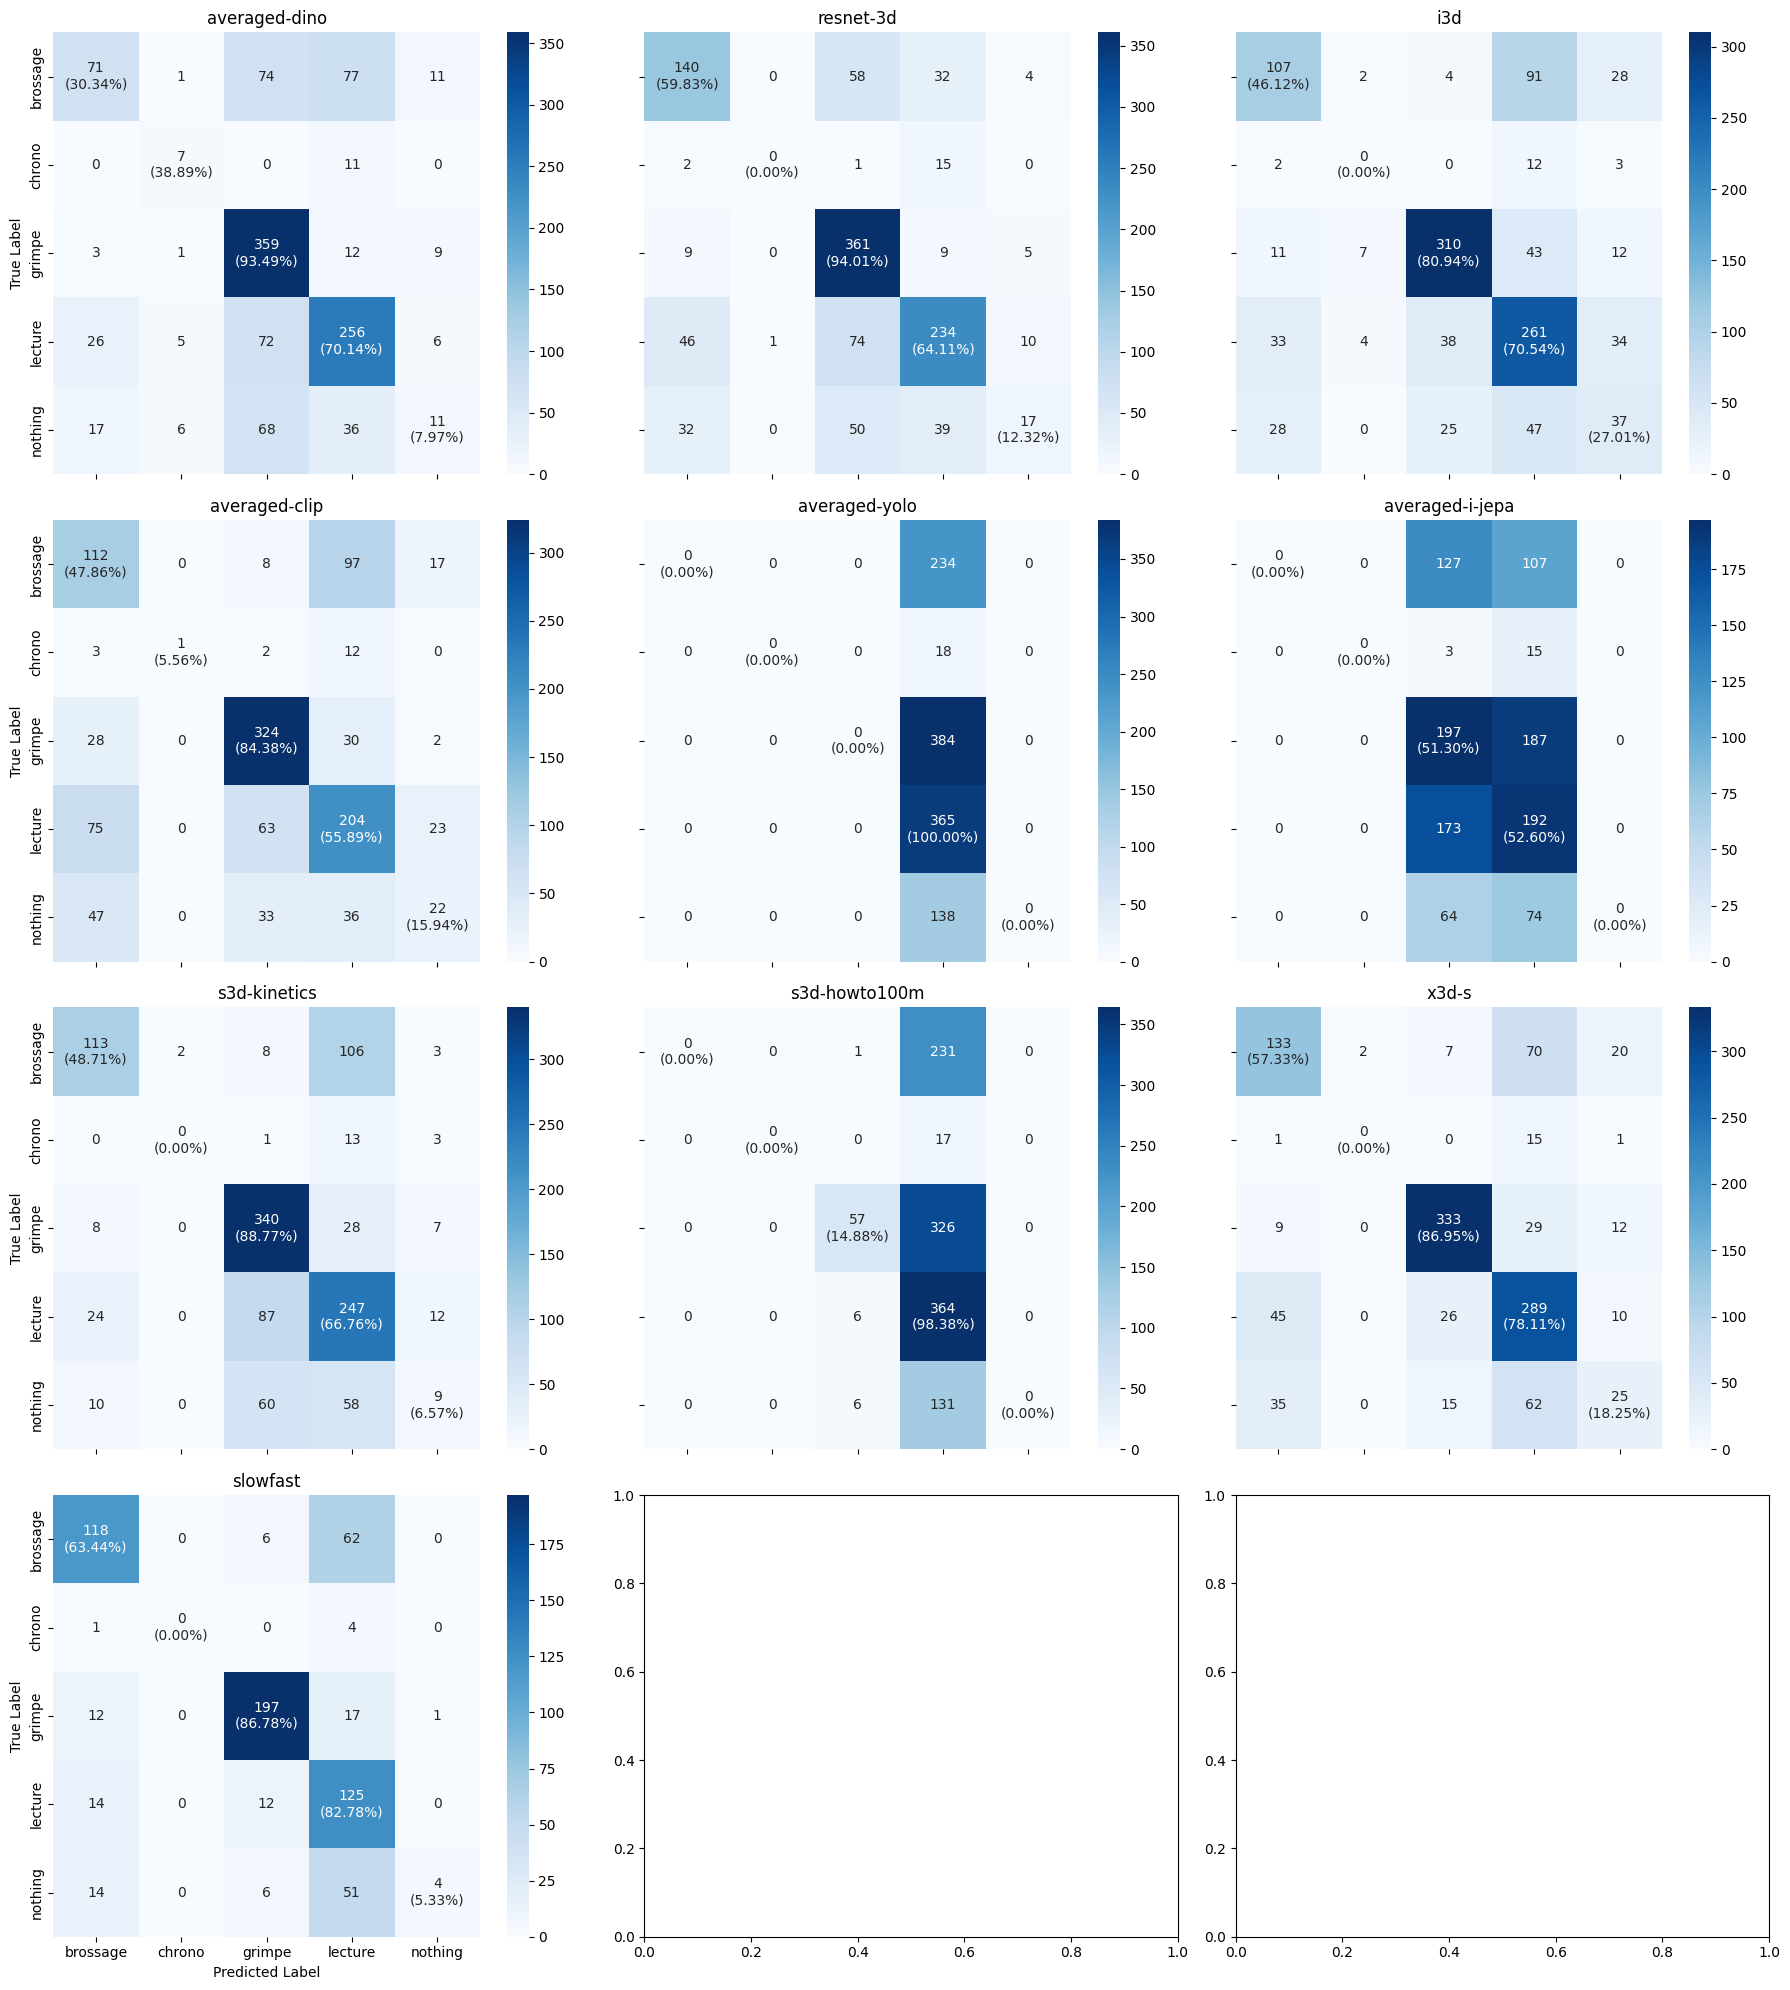

In [22]:
# Function to compute per-class accuracy
def compute_per_class_accuracy(conf_matrix):
    return conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Store per-class accuracies
per_class_accuracies = {}

# Determine grid size for subplots
num_models = len(FEATURES_EXTRACTORS)
cols = min(3, num_models)  # Maximum 3 columns for readability
rows = (num_models + cols - 1) // cols  # Compute required rows

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = np.array(axes)  # Ensure axes is always a NumPy array
axes = axes.flatten()  # Flatten in case of a single row

for idx, (classifier, extractor, training_dataset, testing_dataset) in enumerate(
    zip(classifiers, FEATURES_EXTRACTORS, cached_datasets["training"], cached_datasets["testing"])
):
    model_name = extractor["name"]

    # Get model predictions & ground truth labels
    all_preds = []
    all_labels = []

    classifier.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in torch.utils.data.DataLoader(testing_dataset, batch_size=32, shuffle=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = classifier(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Compute per-class accuracy
    per_class_acc = compute_per_class_accuracy(conf_matrix)
    per_class_accuracies[model_name] = per_class_acc

    # Modify matrix values: put per-class accuracy on diagonal
    conf_matrix_display = conf_matrix.astype(str)  # Convert to string for annotations
    for i in range(len(per_class_acc)):
        conf_matrix_display[i, i] = f"{conf_matrix[i, i]}\n({per_class_acc[i]:.2%})"

    # Plot the confusion matrix in the corresponding subplot
    ax = axes[idx]
    sns.heatmap(conf_matrix, annot=conf_matrix_display, fmt="", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)

    # Only show x-axis label for bottom row
    if idx // cols == rows - 1:
        ax.set_xlabel("Predicted Label")
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    # Only show y-axis label for leftmost column
    if idx % cols == 0:
        ax.set_ylabel("True Label")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.set_title(f"{model_name}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

---

### About Dino

<div class="alert alert-info">

**Dino Model Card:** https://github.com/facebookresearch/dinov2/blob/main/MODEL_CARD.md

**Dino for Video Classification:** https://github.com/facebookresearch/dinov2/issues/16

**Note on UniformTemporalSubSample Size:** Increasing it will give better results but increase loading time. https://github.com/facebookresearch/dinov2/issues/16#issuecomment-1521403076

</div>

<div class="alert alert-warning">

**`patchtokens`** are the image token / patches embeddings after they have been passed through the network and the 324 is here because we have a total of 324 patches.

**`clstoken`** is the cls token that is supposed to contain all the relevant information about the image.

**`regtokens`** are regularization tokens and they only help improve feature diversity and representation during training. Only 4 are used in this model.

**`prenorm`** is represent the combined tokens before the layer normalization (1 [CLS Token] + 4 Regularization Tokens + 324 Patch Tokens = 329).

The 768 is the patch embedding size that is used by Deno. And the 16 that keeps reappearing is the batch size since we are using a sample of 16 frames.

```bash
[features.keys()]: dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])
[number_of_patches]: 324
[x_norm_clstoken]: torch.Size([16, 768])
[x_norm_regtokens]: torch.Size([16, 4, 768])
[x_norm_patchtokens]: torch.Size([16, 324, 768])
[x_prenorm]: torch.Size([16, 329, 768])
[masks]: None
```

</div>

<div class="alert alert-success">

**Questions**
- [ ] Why are we using the last hidden state rather than the last memory cell or output ?

</div>

---

### About I-Jepa

<div class="alert alert-warning">


- [ ] **Checkout** [This Site](https://paperswithcode.com/sota/action-classification-on-kinetics-600?p=video-swin-transformer) for a leaderboard on video classification task.

- [ ] Experiment with features from I-Jepa
- [ ] Experiment with features from VideoMAE-ViT-H/16; OmniMAE-ViT-H/16 and VideoMAEv2-ViT-g/14 and other ViT based models for features extraction.
- [ ] Experiment on fine tuning ViT for a specific task using some unlabelled videos or reinforcement learning.
- [ ] Try to perform some sort of clustering and visualizations on using Umap and PCA on these extracted features on different models, do this for features from different models such as ViT, resnet, Video CNNs, etc.

</div>

<div class="alert alert-warning">

- [ ] Is this [Repository](https://github.com/kylemin/S3D) the same as the one we took the S3D model from ?

</div>

<div class="alert alert-info">

**Introduction Video About Image-Jepa:** https://www.youtube.com/watch?v=6bJIkfi8H-E

**V-Jepa Paper:** [Here](https://scontent-lhr8-2.xx.fbcdn.net/v/t39.2365-6/427986745_768441298640104_1604906292521363076_n.pdf?_nc_cat=103&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=G-D4kApr8TQQ7kNvgFSoEBh&_nc_oc=AdiZo1b5QaDaQaf0hctrozKJ2vjIp_iQvUZxArm_8k3ngVZNVLtltyVFidEIN-Njt9g&_nc_zt=14&_nc_ht=scontent-lhr8-2.xx&_nc_gid=AzzCS9ed8AZ-B2iLuVB7EE0&oh=00_AYB3kfkI_sVH0UVTrzunG99_ThmOVCNN7sRu9q9XS7nAPw&oe=67BCDFF1).

</div>